In [1]:
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
Base.classes.keys()

['measurements', 'stations']

In [5]:
m_columns = inspect(engine).get_columns("measurements")
for column in m_columns:
    print(column["name"], column["type"])

id INTEGER
station VARCHAR(255)
date VARCHAR(255)
prcp FLOAT
tobs INTEGER


In [6]:
s_columns = inspect(engine).get_columns("stations")
for column in s_columns:
    print(column["name"], column["type"])

station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [8]:
session = Session(bind=engine)

In [9]:
# Get the most recent date.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date

'2017-08-23'

In [10]:
# Get the date of 12 months ago.
first_date = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)
first_date

datetime.datetime(2016, 8, 23, 0, 0)

## Precipitation Analysis

In [11]:
# The last 12 months of precipitation data.
q1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > first_date)
df1 = pd.read_sql(q1.statement, conn).set_index("date")
df1.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [12]:
locs = np.linspace(5, df1.shape[0]-2, num=9)
labels = [df1.index[int(_)] for _ in locs]

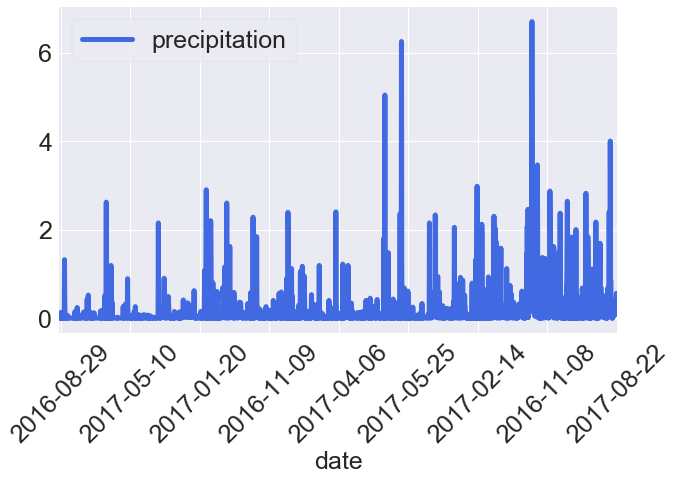

In [13]:
plt.style.use("seaborn")
df1.plot(y="prcp", use_index=True, c="royalblue", lw=5, label="precipitation", figsize=(10,6))
plt.xlabel("date", size=25)
plt.xticks(locs, labels, size=25, rotation=45)
plt.yticks(range(0,8,2), size=25)
plt.xlim(0,df1.shape[0])
plt.legend(loc="upper left", fontsize=25, frameon=True)
plt.show()

In [14]:
# The summary statistics for the precipitation data.
df1["prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

## Station Analysis

In [15]:
# The total number of stations.
session.query(Station.station).count()

9

In [16]:
# The most active stations by observation counts.
q2 = session.query(Station.station, func.count(Measurement.id)).filter(Station.station == Measurement.station).\
group_by(Station.station).order_by(func.count(Measurement.id).desc())
q2.all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [17]:
# The last 12 months of temperature observation data (tobs) at Station USC00519281.
q3 = session.query(Measurement.tobs).filter(Measurement.date > first_date).filter(Measurement.station == q2.first()[0])
q3_temps = [q3.all()[_][0] for _ in range(len(q3.all()))]

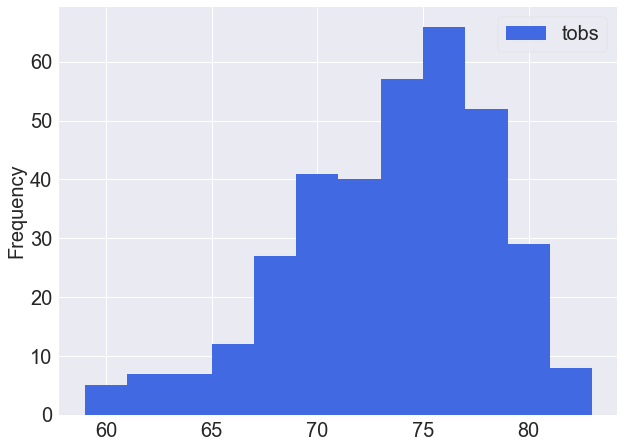

In [18]:
plt.figure(figsize=(10,7.5))
plt.hist(q3_temps, bins=12, color="royalblue", label="tobs")
plt.ylabel("Frequency", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20, frameon=True)
plt.show()

## Temperature Analysis

In [19]:
def calc_temps(start_date, end_date):
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).one()[0]
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).one()[0]
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).one()[0]
    return avg_temp, max_temp, min_temp

In [20]:
# Temperatures for my trip using the matching dates from the previous year.
trip_temps = calc_temps("2017-01-01", "2017-01-07")
trip_temps

(68.1025641025641, 74, 62)

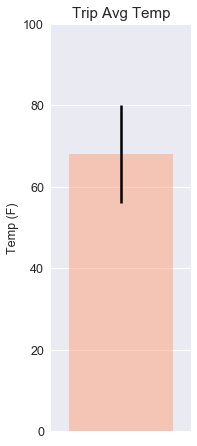

In [21]:
plt.figure(figsize=(2.5,7.5))
plt.bar(0, trip_temps[0], yerr=trip_temps[1]-trip_temps[2], color="lightsalmon", width=.75, alpha=.5, 
        error_kw={"elinewidth": 2.5})
plt.title("Trip Avg Temp", size=15)
plt.ylabel("Temp (F)", size=12.5)
plt.xticks([])
plt.yticks(size=12.5)
plt.xlim(-.5,.5)
plt.ylim(ymax=100)
plt.show()

## Bonus

In [22]:
# The rainfall per weather station using the previous year's matching dates.
session.query(Measurement.station, Measurement.date, Measurement.prcp).\
filter(Measurement.date.between("2017-01-01", "2017-01-07")).all()

[('USC00519397', '2017-01-01', 0.0),
 ('USC00519397', '2017-01-02', 0.0),
 ('USC00519397', '2017-01-03', 0.0),
 ('USC00519397', '2017-01-04', 0.0),
 ('USC00519397', '2017-01-05', 0.0),
 ('USC00519397', '2017-01-06', 0.0),
 ('USC00519397', '2017-01-07', 0.0),
 ('USC00513117', '2017-01-01', 0.29),
 ('USC00513117', '2017-01-02', 0.0),
 ('USC00513117', '2017-01-03', 0.0),
 ('USC00513117', '2017-01-04', 0.0),
 ('USC00513117', '2017-01-05', 0.0),
 ('USC00513117', '2017-01-06', 0.0),
 ('USC00513117', '2017-01-07', 0.06),
 ('USC00514830', '2017-01-01', 0.0),
 ('USC00514830', '2017-01-02', 0.01),
 ('USC00514830', '2017-01-03', 0.0),
 ('USC00514830', '2017-01-04', 0.0),
 ('USC00514830', '2017-01-05', 0.0),
 ('USC00514830', '2017-01-06', 0.59),
 ('USC00514830', '2017-01-07', 0.0),
 ('USC00519523', '2017-01-04', 0.18),
 ('USC00519523', '2017-01-05', 0.42),
 ('USC00519523', '2017-01-06', 0.01),
 ('USC00519523', '2017-01-07', 0.0),
 ('USC00519281', '2017-01-01', 0.03),
 ('USC00519281', '2017-01-02',

In [23]:
# Calculate the daily normals. Normals are the averages (by year) for min, avg, and max temperatures (by date).
def daily_normals(date):
    q_avg = session.query(func.avg(Measurement.tobs).label("avgs")).filter(func.strftime("%m-%d", Measurement.date) == date).\
    group_by(Measurement.date)
    q_max = session.query(func.max(Measurement.tobs).label("maxs")).filter(func.strftime("%m-%d", Measurement.date) == date).\
    group_by(Measurement.date)
    q_min = session.query(func.min(Measurement.tobs).label("mins")).filter(func.strftime("%m-%d", Measurement.date) == date).\
    group_by(Measurement.date)
    avg = session.query(func.avg(q_avg.subquery().columns.avgs)).one()[0]
    max = session.query(func.avg(q_max.subquery().columns.maxs)).one()[0]
    min = session.query(func.avg(q_min.subquery().columns.mins)).one()[0]
    return date, avg, max, min

In [24]:
dates = ["01-" + str(_+1).zfill(2) for _ in range(7)]
dates

['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']

In [25]:
normals = [daily_normals(date) for date in dates]
normals

[('01-01', 68.98154761904762, 73.625, 64.75),
 ('01-02', 69.4077380952381, 73.625, 65.625),
 ('01-03', 68.75803571428571, 72.75, 64.75),
 ('01-04', 69.68199404761904, 74.0, 64.5),
 ('01-05', 68.16919642857144, 72.75, 64.125),
 ('01-06', 69.13333333333333, 73.0, 65.25),
 ('01-07', 68.671875, 72.25, 63.375)]

In [26]:
df2 = pd.DataFrame(normals, columns=["date", "tavg", "tmax", "tmin"]).set_index("date")
df2

,tavg,tmax,tmin
date,,,
01-01,68.981548,73.625,64.750
01-02,69.407738,73.625,65.625
01-03,68.758036,72.750,64.750
01-04,69.681994,74.000,64.500
01-05,68.169196,72.750,64.125
01-06,69.133333,73.000,65.250
01-07,68.671875,72.250,63.375


C:\Users\Anthony\Anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


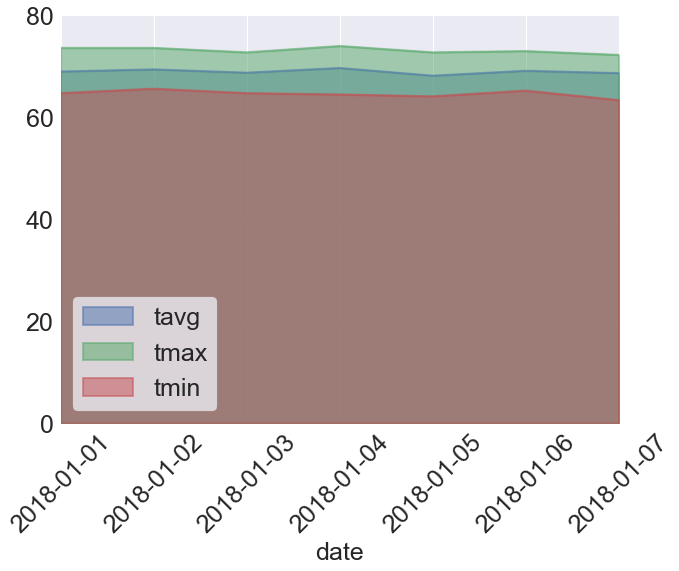

In [27]:
df2.plot(y=["tavg", "tmax", "tmin"], use_index=True, kind="area", stacked=False, lw=2, alpha=.5, figsize=(10,7.5))
plt.xlabel("date", size=25)
plt.xticks(range(7), ["2018-"+ date for date in dates], size=25, rotation=45)
plt.yticks(range(0,100,20), size=25)
plt.xlim(0,6)
plt.legend(loc="lower left", fontsize=25, frameon=True)
plt.show()